# Audio model initial evaluation
Se evalúa un modelo TensorFlow de sonido entrenado.
## Imports

In [1]:
from tensorflow.keras.models import load_model
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from audio_model_evaluation import get_dataset, DIGITS, MICRO, EXT, PRUN, QAT

## Parámetros

In [2]:
model = QAT
data_origin = EXT

project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"

if model in [EXT, PRUN, QAT]:
    if model == EXT:
        model_name = "ExtAudioDataModel"
    elif model == PRUN:
        model_name = "ExtAudioDataModelPrun"
    else:
        model_name = "ExtAudioDataModelQAT"

    if data_origin == EXT:
        test_dir = f"{project_dir}/samples/external/audio/test"
    else:
        test_dir = f"{project_dir}/samples/microcontroller/audio/all"
else:
    model_name = "MicroAudioDataModel"

    if data_origin == EXT:
        test_dir = f"{project_dir}/samples/external/audio/all"
    else:
        test_dir = f"{project_dir}/samples/microcontroller/audio/test"

saved_models_dir = f"{project_dir}/saved models/audio"
label_index_dir = f"{saved_models_dir}/label index mappings"
model_dir = f"{saved_models_dir}/tensorflow/{model_name}"

## Carga del modelo
Cargamos un modelo y mostramos un resumen de su estructura.

In [3]:
model = load_model(model_dir)
model.summary()

class_names = load(f"{label_index_dir}/{model_name}.joblib")
class_indexes = {}
for index, name in enumerate(class_names):
    class_indexes[name] = index

Model: "ExtAudioDataModelQAT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 40, 49, 1)         3         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 17, 20, 8)         667       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 8, 10, 8)          1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 8, 10, 8)          1         
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 640)               1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 4)                 2569      
Total params: 3,242
Trainable params: 3,212
Non-trainable params: 30
___________________________________________

## Carga de datos de test
Cargamos los datos de test sobre los que se realizará inferencias.

In [4]:
test_dataset = get_dataset(test_dir)

test_audios = []
test_labels = []
for audio, label in test_dataset:
    test_audios.append(audio.numpy())
    test_labels.append(label.numpy())
test_audios = np.array(test_audios)
test_labels = np.array(test_labels)

Using 3230 samples.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


## Inferencia
Se realiza inferencia sobre los archivos de la carpeta test y se muestran los resultados.

In [5]:
predictions = np.argmax(model.predict(test_audios), axis=1)

## Visualización de métricas

Se muestran datos acerca del comportamiento general del modelo al evaluar las muestras.

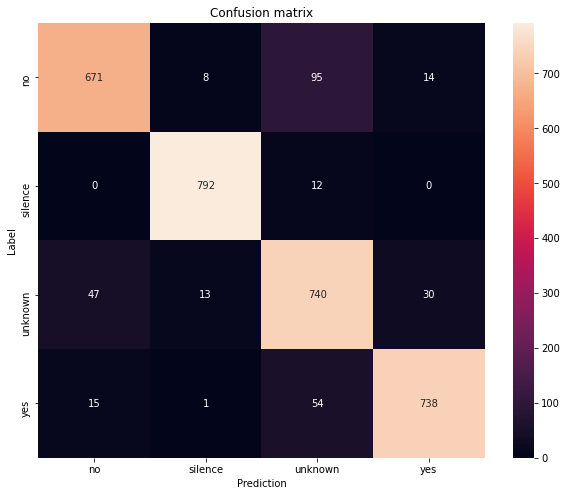

              precision    recall  f1-score   support

          no    0.91542   0.85152   0.88231       788
     silence    0.97297   0.98507   0.97899       804
     unknown    0.82131   0.89157   0.85500       830
         yes    0.94373   0.91337   0.92830       808

    accuracy                        0.91053      3230
   macro avg    0.91336   0.91038   0.91115      3230
weighted avg    0.91264   0.91053   0.91086      3230



In [6]:
confusion_mtx = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion matrix")
plt.show()
print(classification_report(test_labels, predictions, target_names=class_names, digits=DIGITS))